# The basics of Bayesian optimization

Many real-world problems involve optimization of functions which are difficult, or costly, to evaluate. For instance, in deep learning, finding the optimal hyperparameters and architecture of a neural network is a cumbersome process that should ideally be automated with as little fuction evaluations (i.e. training the networks) as possible. For problems like these, Bayesian optimization (BO) offers a unifying framework where the function to evaluate is approximated using a surrogate model. 

In this notebook, we introduce the basics of BO. More specifically, we are interested in optimizing some function $f: \mathcal{X} \rightarrow \mathbb{R}$ on some set $ \mathcal{X} \subset \mathbb{R}^p$, i.e., to find

\begin{equation}
\mathbf{x}_{\min} =  \arg \max_{x \in \mathcal{X}} f(\mathbf{x})
\end{equation}

We assume that we are allowed to query $f$ at $\mathbf{x}_i$ which will yield us a noisy observation $y_i$ for every query $i$. We will approximate $f$ using a probabilistic model, namely a Gaussian process. To optimize $f$, we will fit a GP to the currently available data $\mathcal{D} = \{\mathbf{x}_i, y_i\}_{i=1}^n$, then find the next point $\mathbf{x}_{n + 1}$ with some appropriate *acqusition function*, query it to receive $y_{n + 1}$ and then repeat the procedure for a certain number of iterations $N$.

Throughout this notebook, we will use [*Stan*](https://mc-stan.org/) to fit the surrogate model. Some introductory  references on Bayesian optimization include: [Snoek *et al.* (2012)](https://arxiv.org/abs/1206.2944), [Shahriari *et al.* (2015)](https://ieeexplore.ieee.org/document/7352306) and [Frazier (2018)](https://arxiv.org/abs/1807.02811). Feedback and comments are welcome!

In [1]:
suppressMessages({    
    library(ggplot2)
    library(cowplot)
    library(pracma)
    library(rdist)
    
    library(rstan)    
})

options(repr.plot.width = 11, repr.plot.height = 3, repr.plot.res = 360)
set.seed(23)

For convenience, we define a method to plot the GP fit and data.

In [2]:
scatterplot <- function(x.true, y.true, f_star = NULL, f_star_var = NULL, data = NULL) {  
  df <- data.frame(x = x.true, y = y.true)

  g <- ggplot() +
    theme(
        axis.line.x = element_line(color = "black", size = .25),
        axis.line.y = element_line(color = "black", size = .25),
        axis.text = element_text(size=12),
        axis.title = element_text(size=13),
        legend.text = element_text(size=13)
    )    

  if (!is.null(f_star) && !is.null(f_star_var)) {
    df_star <- data.frame(
      x = x.true,
      y = f_star,
      lower = f_star - sqrt(f_star_var),
      upper = f_star + sqrt(f_star_var)
    )
    g <- g +
      geom_ribbon(
        data = df_star,
        aes(x, ymin = lower, ymax = upper, fill = "#DCBCBC")
      ) +
      geom_line(data = df_star, aes(x, y, color = "darkred"))
  }

  if (!is.null(data)) {
    g <- g + geom_point(data = data, aes(x, y, color = "darkred"))
  }

  g +
    geom_line(data = df, aes(x, y, color = "darkgrey")) +
    scale_color_manual(
      breaks = c("darkgrey", "darkred", "black"),
      labels = c("Function to optimize", "Posterior", "Acquisition function"),
      values = c("darkgrey", "darkred", "black")
    ) +
    scale_fill_manual(
      breaks = c("lightgrey", "darkred", "#DCBCBC"),
      values = c("lightgrey", "darkred", "#DCBCBC")
    ) +
    labs(color = NULL) +
    guides(fill = FALSE) +
    theme_cowplot()
}

Usually the function to maximize is difficult/infeasible to query and the number of functions evaluations and we want to minimize the number as much as possible. In this example, we demonstrate Bayesian optimization on the function below.

In [3]:
f <- function(x) cos(4 * x) + exp(-(x ** 2) / 2)

Without loss of generality, we constrain the optimization on a set of $m$ points in the interval $x \in [-5, 5]$, such that we don't need to write to much boilerplate code, i.e., we just evaluate the points and take maxima or minima instead of optiming the function itself.

In [4]:
m <- 1000

x.init = seq(-5, 5, length.out = m)
y.init = f(x.init)

The function to optimize is shown below:

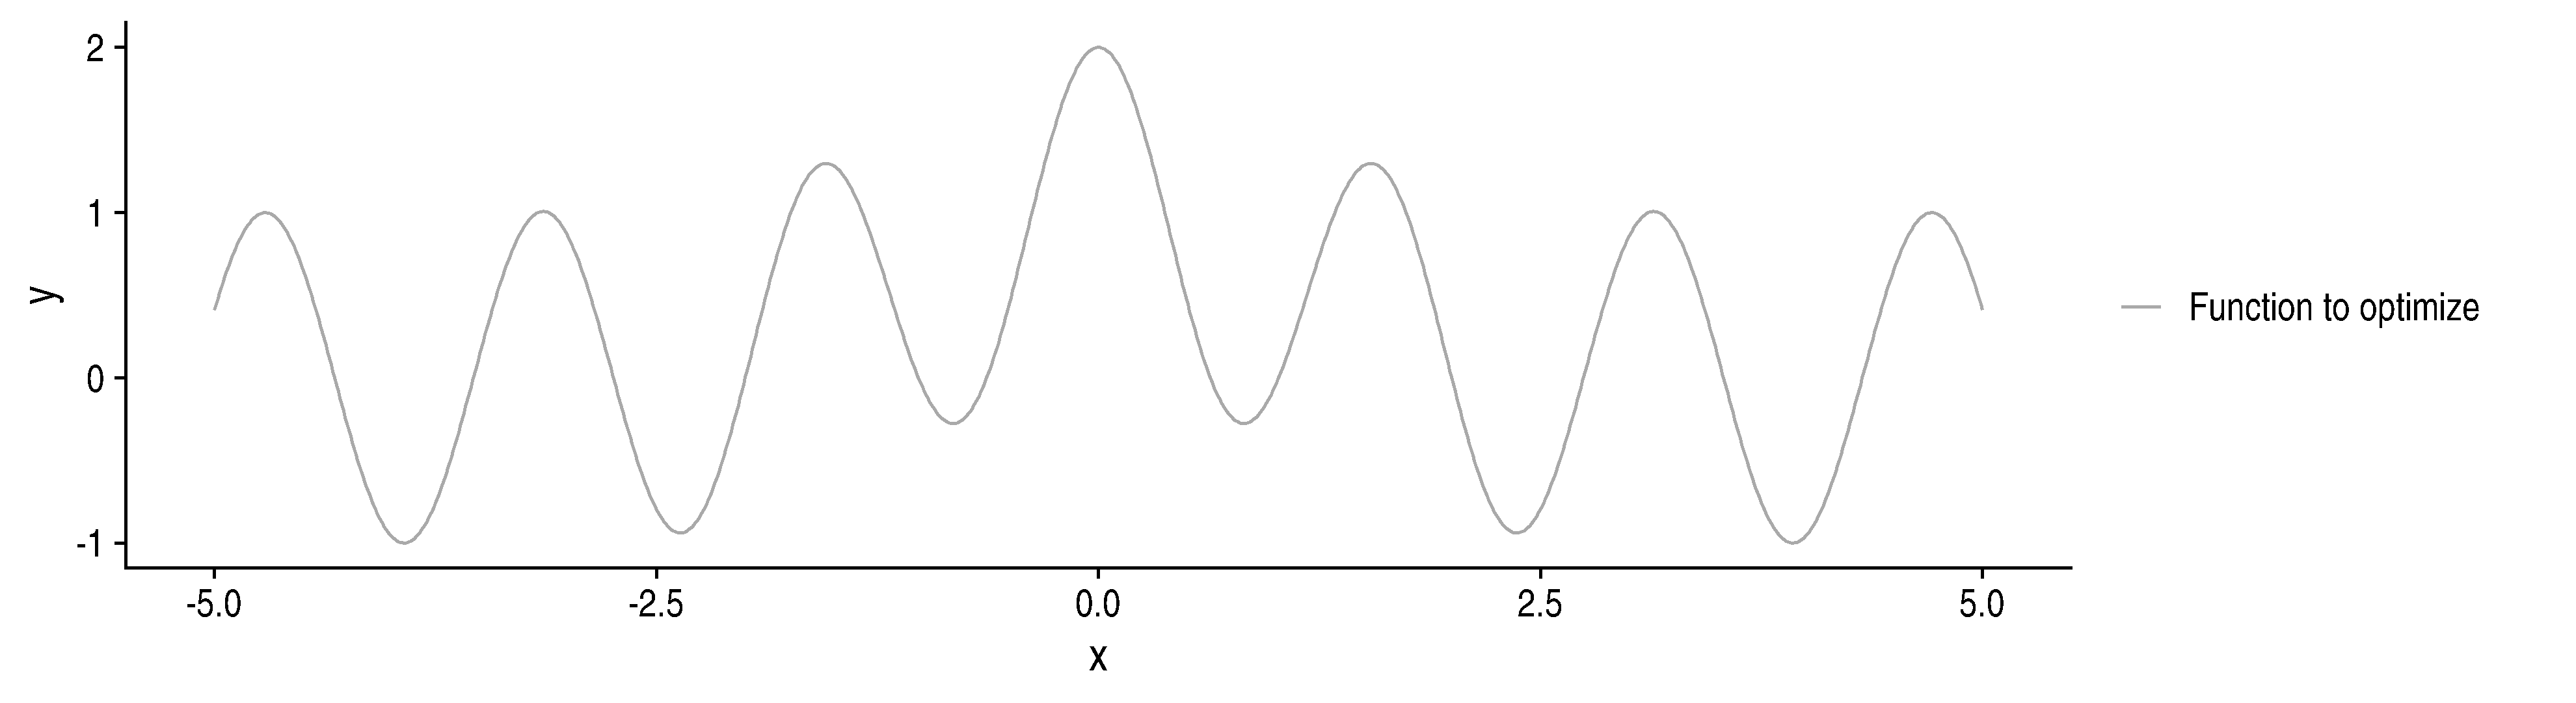

In [5]:
scatterplot(x.init, y.init)

To optimize this function, we define functions to fit a surrogate model and make a predict using the model fit. As mentioned above, we use Stan to implement the GP. The Stan code is fairly short. It takes the data, a set of points for which predictions should be made and kernel hyperparameters. The model and parameters blocks are actually empty, since here we confine ourselves to not fitting posterior of the kernel parameters. 

In [6]:
surrogate.model.file <- "_models/bo-surrogate.stan"
cat(readLines(surrogate.model.file), sep="\n")

data {
  int<lower=1> N;
  real x[N];
  vector[N] y;

  int<lower=1> N_star;
  real x_star[N_star];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

parameters {}

model {}

generated quantities {
  vector[N_star] f_star;
  vector[N_star] f_star_cov;

  {
    matrix[N, N] K =  cov_exp_quad(x, alpha, rho)
       + diag_matrix(rep_vector(square(sigma), N));
    matrix[N, N] L_K = cholesky_decompose(K);

    vector[N] L_K_div_y = mdivide_left_tri_low(L_K, y);
    vector[N] K_div_y = mdivide_right_tri_low(L_K_div_y', L_K)';

    matrix[N, N_star] k_x_x_star = cov_exp_quad(x, x_star, alpha, rho);


    matrix[N, N_star] v_pred = mdivide_left_tri_low(L_K, k_x_x_star);
    matrix[N_star, N_star] cov_f2 = cov_exp_quad(x_star, alpha, rho) -
        v_pred' * v_pred
        + diag_matrix(rep_vector(1e-10, N_star));

    f_star = (k_x_x_star' * K_div_y);
    f_star_cov = diagonal(cov_f2);
  }
}


Stan requires us to compile the model once such that we can use it. We do that like this:

In [7]:
gp <- stan_model(file = surrogate.model.file)

The predict function takes the data, the points to prediction, and the compiled Stan model.

In [8]:
predict.gp <- function(gp, x.d, y.d, x.star) {
    dat <- list(
        N=length(x.d),
        x=array(x.d),
        y=array(y.d),
        N_star=length(x.star),
        x_star=array(x.star),
        rho=1,
        alpha=1,
        sigma=1
    )
    
    pred <- rstan::sampling(
        gp, dat, chains=1, algorithm="Fixed_param", iter=1, show_messages=FALSE, refresh=0
    )

    ext <- rstan::extract(pred)
    f.star <- as.vector(ext$f_star)
    f.star.var <- as.vector(ext$f_star_cov)
    
    
    list(f.star, f.star.var)
}

In [9]:
. <- predict.gp(gp, x.init[1], y.init[1], x.init)

As acquisition function we use the upper confidence bound (see [Snoek *et al*](https://arxiv.org/abs/1206.2944)) which is computed from the predictive posterior mean $\mu(\mathbf{x})$ and variance $\sigma^2(\mathbf{x})$ of the surrogate model:

\begin{equation}
a(\mathbf{x}) = \mu(\mathbf{x}) + \kappa \sigma(\mathbf{x})
\end{equation}

where $\kappa$ can be tuned to balance betwen exploitation and exploration,

In [10]:
acquisition.function <- function(gp, x.d, y.d, x.init, conf) {
    preds <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- preds[[1]]
    f.star.var <- preds[[2]]
    ucb <- f.star + conf * sqrt(f.star.var)
    ucb
}

Finally, we define a function that proposes the next point to evaluate.

In [11]:
acquire <- function(x.d, y.d, x.init, conf=2.0) {
    preds  <- predict.gp(gp, x.d, y.d, x.init)
    f.star <- preds[[1]]
    f.star.var <- preds[[2]]
    ucb <- acquisition.function(gp, x.d, y.d, x.init, conf)
    x.next <- x.init[which.max(ucb)]
    
    list(
        x.next=x.next,
        ucb=ucb,
        f.star=f.star,
        f.star.var=f.star.var
    )
}    

We start with a random point on the interval defined above and query it against the function that we want to optimize.

In [12]:
set.seed(23)

x.d <- runif(1, -5, 5)
y.d <- f(x.d)

Then we train the surrogate model, and use the aquisition function to propose a new point.

In [13]:
iter <- acquire(x.d, y.d, x.init)
x.n  <- iter$x.next
ucb  <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.var

For the acquisition of the first point, we first fit the data (consisting of one observation) to the GP. The posterior mean is shown in red, and the posterior variance in lightred. We then compute the acquisition function on a set of $m$ points in the interval $x \in [-5, 5]$ and take its maximizer. The entire acquisition function is shown as black line. Its maximizer is the black point.

Note how the acquisition has a dent around the data $(x_1, y_1)$, since the variance (but also the mean in this case) at this point is reducing the function value.

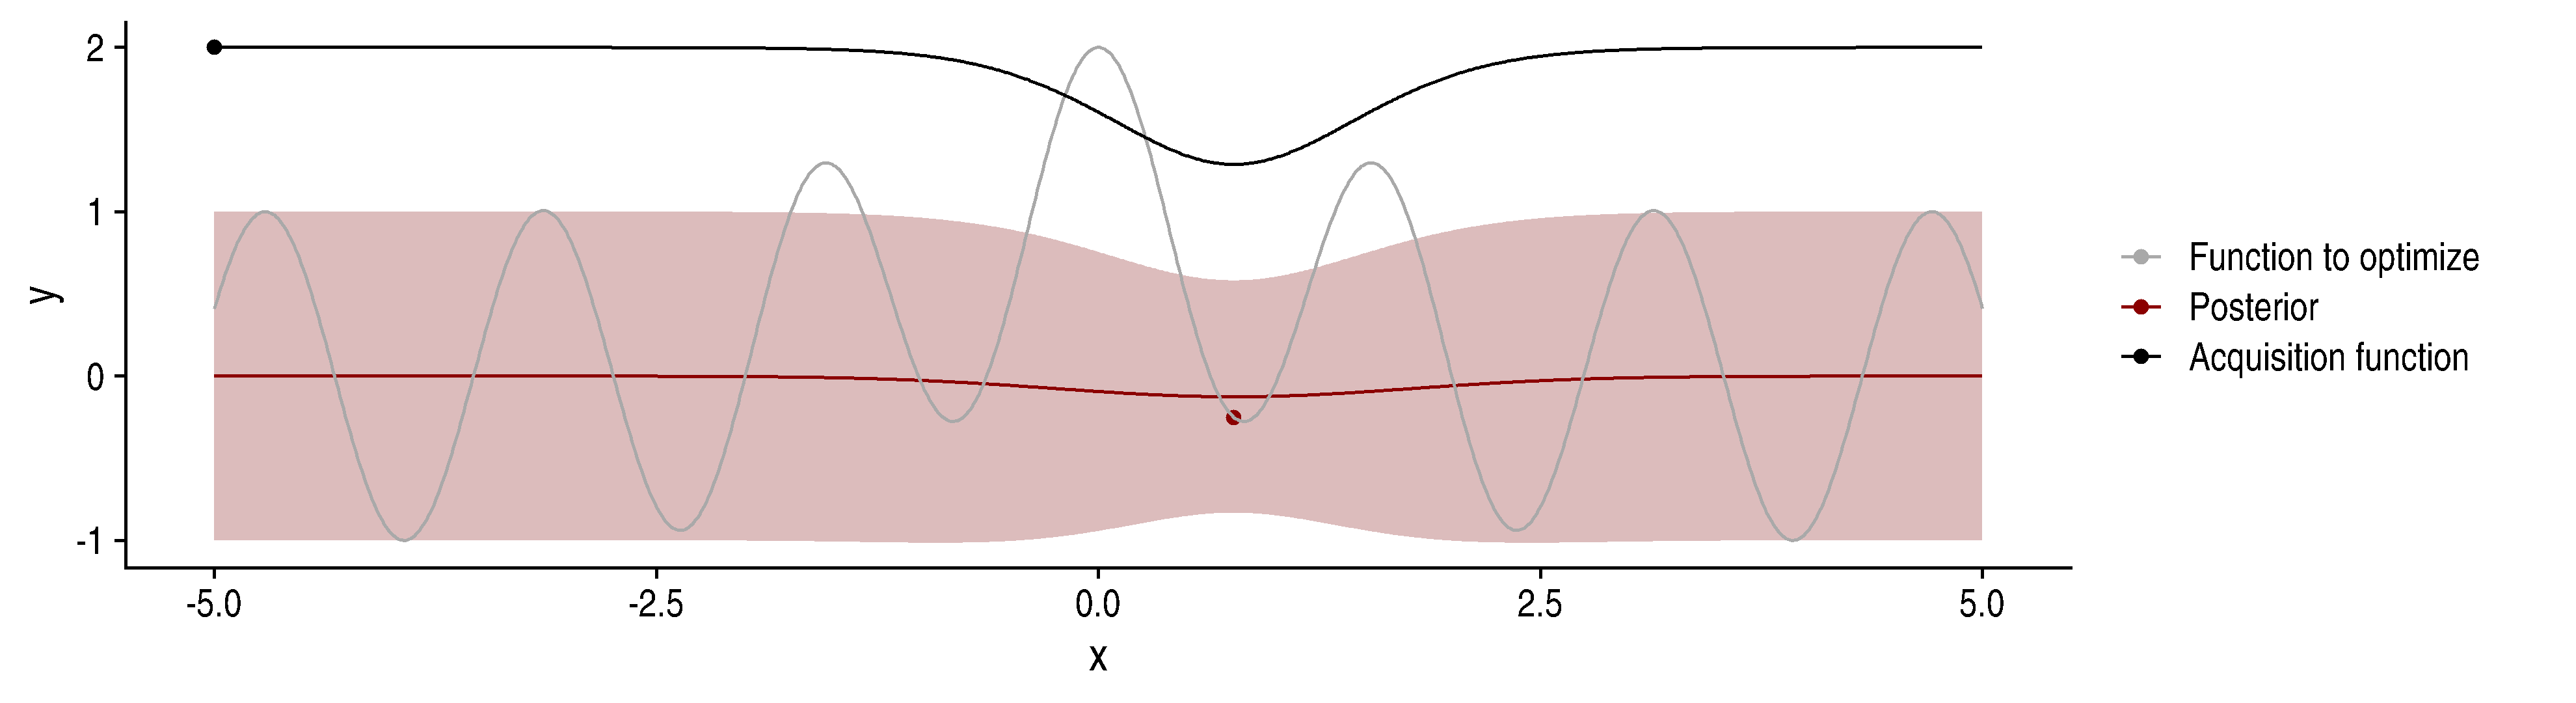

In [14]:
scatterplot(
    x.init, y.init, f.star, f.star.var,
    data = data.frame(x = x.d, y = y.d)
  ) +
  geom_line(
    data = data.frame(x = x.init, y = ucb),
    aes(x, y, color = "black")
  ) +
  geom_point(
    data = data.frame(x = x.n, y = max(ucb)),
    aes(x, y)
  )

We then evaluate the point and add it to the data.

In [15]:
y.n <- f(x.n)
x.d <- c(x.d, x.n)
y.d <- c(y.d, y.n)

We can repeat this process of querying points and then acquiring new points as often as we want, until we think we have a good estimate of the maximum of $f$, since we don't have its functional form.

In [16]:
iter <- acquire(x.d, y.d, x.init)

In [17]:
x.n <- iter$x.next
ucb <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

The data now consists of two observations, hence the acqusition functions has to dents here.

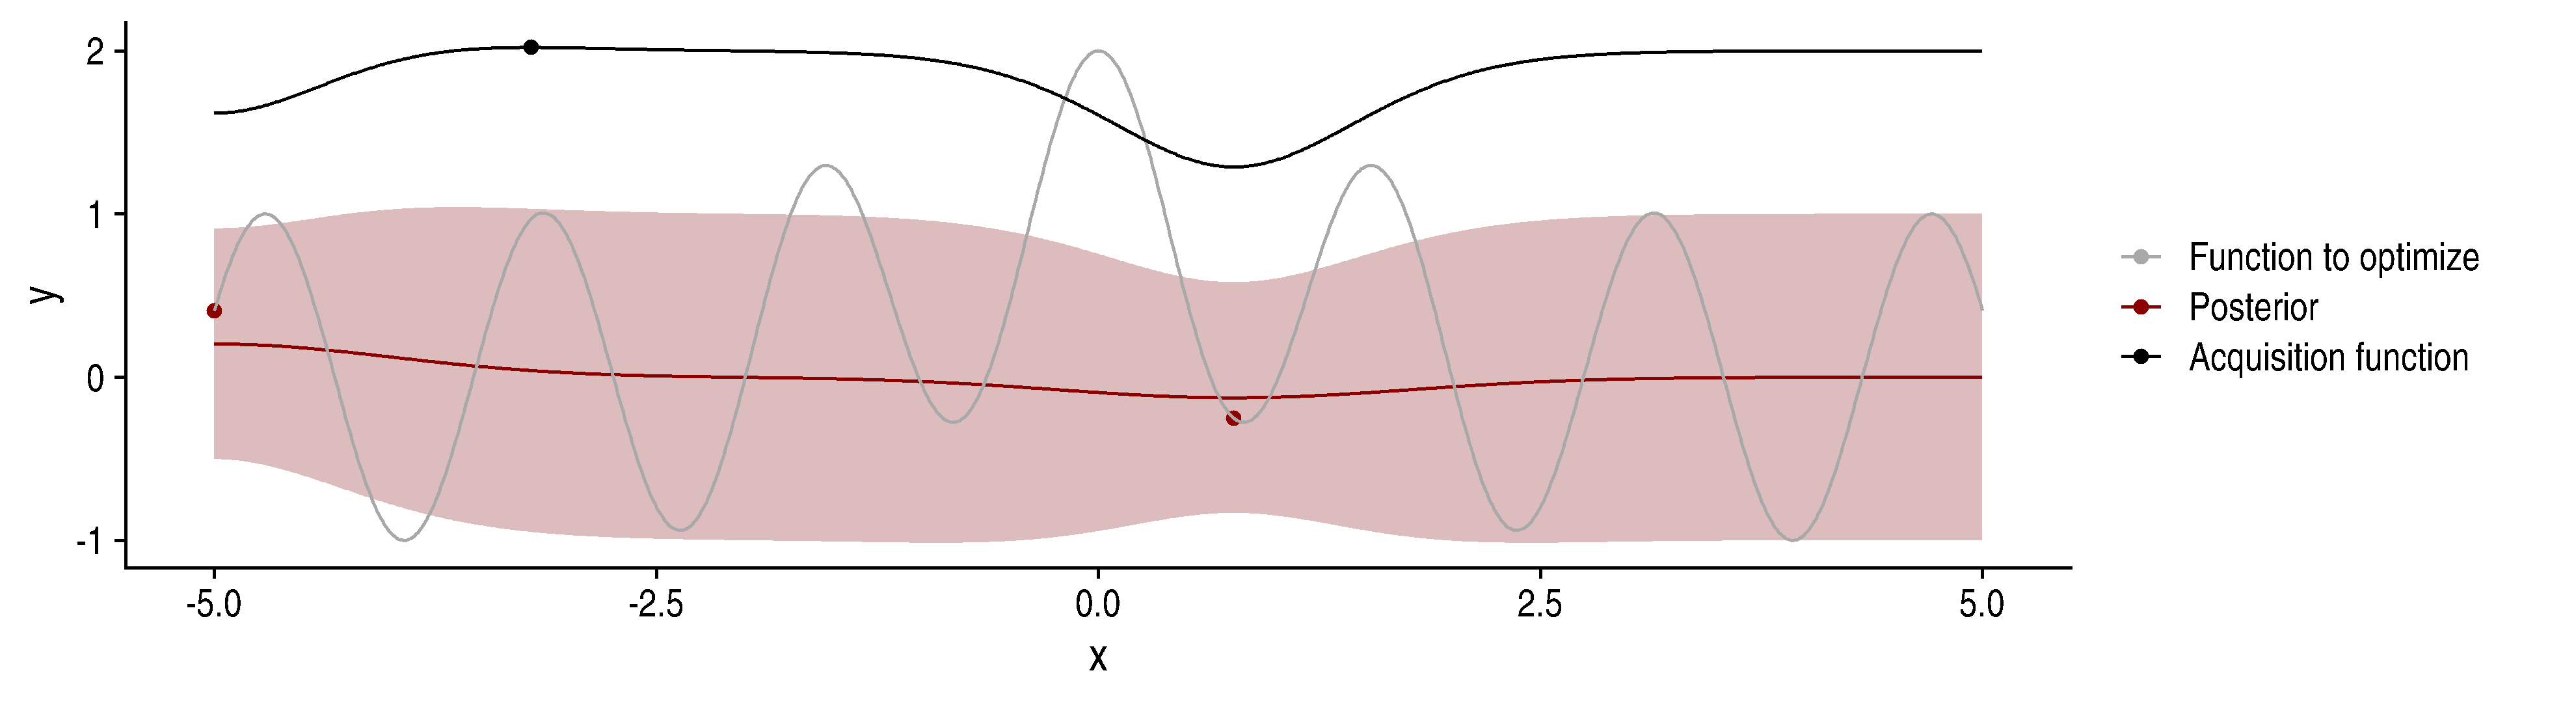

In [18]:
scatterplot(
    x.init, y.init, f.star, f.star.var,
    data = data.frame(x = x.d, y = y.d)
  ) +
  geom_line(
    data = data.frame(x = x.init, y = ucb),
    aes(x, y, color = "black")
  ) +
  geom_point(
    data = data.frame(x = x.n, y = max(ucb)),
    aes(x, y)
  )

Let's repeat this procedure for a couple of times, i.e., propose a point, evaluate it, and repeat.

In [19]:
for (i in seq(20)) {
    y.n <- f(x.n)
    x.d <- c(x.d, x.n)
    y.d <- c(y.d, y.n)
    iter <- acquire(x.d, y.d, x.init)
    x.n <- iter$x.next
}

For the last iteration, we extract the acquisition function, and posterior mean and variance, and plot all iterations.

In [20]:
ucb    <- iter$ucb
f.star <- iter$f.star
f.star.var <- iter$f.star.v

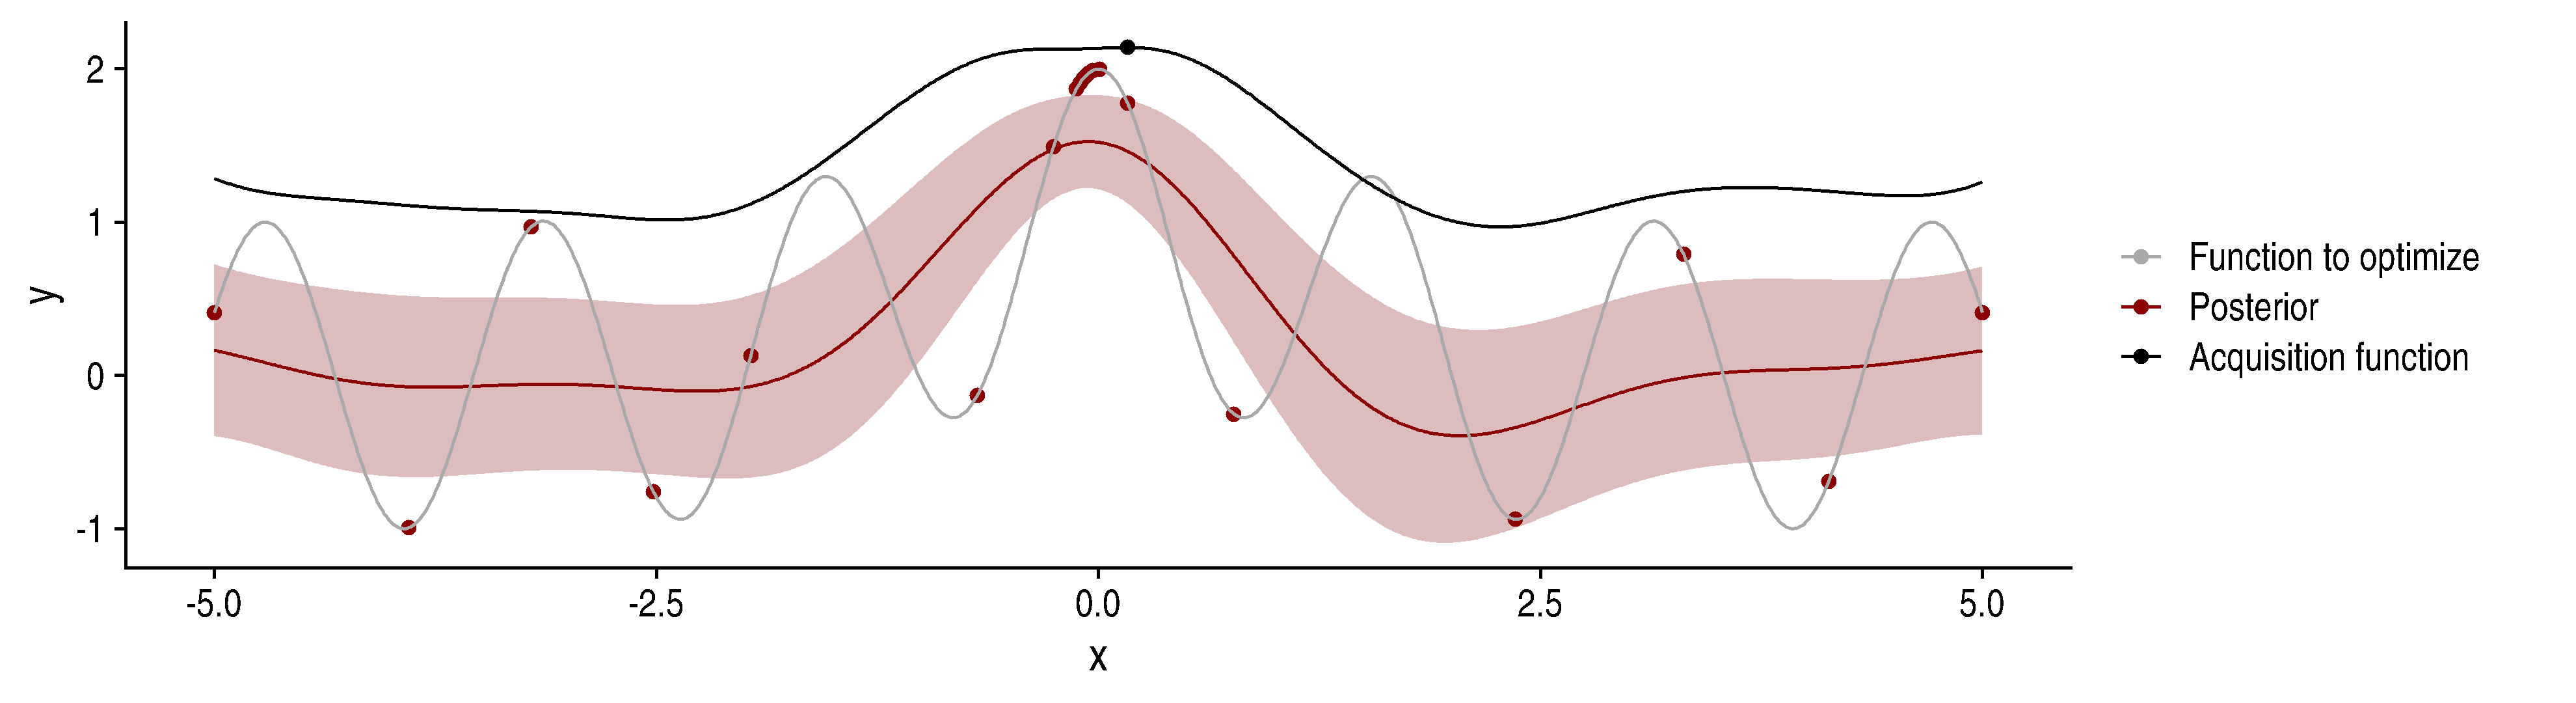

In [21]:
scatterplot(
    x.init, y.init, f.star, f.star.var,
    data = data.frame(x = x.d, y = y.d)
  ) +
  geom_line(
    data = data.frame(x = x.init, y = ucb),
    aes(x, y, color = "black")
  ) +
  geom_point(
    data = data.frame(x = x.n, y = max(ucb)),
    aes(x, y)
  )

This worked nicely. While some of the points are spread around the entire domain of $\mathcal{X}$, an increasing number centers around the function's maximum.

## License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img align="left" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a> <br>

The notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.